# **Deep Learning - LSTM**

No que diz respeito a modelos de *deep learning*, optámos por utilizar uma rede **LSTM** (Long Short-Term Memory) devido à sua capacidade de modelar dependências temporais e padrões complexos em séries temporais. Para além disso, estas redes permitem-nos lidar com longas sequências de dados, capturando informações relevantes ao longo do tempo, , o que as torna particularmente eficazes na previsão de ações financeiras.


>Referência: *A deep learning framework for financial time series using stacked autoencoders and long-short term memory" Wei Bao, Jun Yue, Yulei Rao *

**Bibliotecas Necessárias**

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt       
import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

**Ler e separar os dados**

In [220]:
file_path = 'Data_noNorm.csv'
data = pd.read_csv(file_path)

# Garantir que a coluna 'Date' está no formato correto e sem o fuso horário
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Separar o conjunto de teste (janeiro de 2024)
test_data = data.loc['2024-01-01':'2024-01-31']

# Separar treino e validação (2010–2023)
train_val_data = data.loc[:'2023-12-31']

# Dividir treino e validação
train_data = train_val_data.loc[:'2022-12-31']  # Treino até dezembro de 2022
val_data = train_val_data.loc['2023-01-01':'2023-12-31']  # Validação: ano de 2023

**Escolha das melhores features, com recurso ao modelo LightGBM**

De modo a fazermos a escolha das melhores *features*, optamos por utilizar o **LightGBM**, por ser um modelo com elevada capacidade em lidar com um grande volume de dados e com padrões complexos.\
Além disso, apresenta uma boa eficiência computacional, sem introduzir ruído.

>Referência: *Ke, Guolin, et al. "LightGBM: A highly efficient gradient boosting decision tree." Advances in Neural Information Processing Systems. 2017*

In [224]:
#Para o LGB
X_train_lgb = train_data.drop(columns=['Future_Return'])  #Future_Return (target)
y_train_lgb = train_data['Future_Return']  # Target

In [225]:
# Seleção de features com base na importância do LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=200, max_depth=25, learning_rate=0.1, random_state=42)
lgb_model.fit(X_train_lgb, y_train_lgb)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4906
[LightGBM] [Info] Number of data points in the train set: 1516448, number of used features: 23
[LightGBM] [Info] Start training from score 0.000723


LGBMRegressor(max_depth=25, n_estimators=200, random_state=42)

In [226]:
feature_importances = lgb_model.feature_importances_
feature_importances

array([  29,   40,   20,   30,   33,  176,  345,   34,   53,   28,  231,
          0,   47,   56,  108,  122,   74,  666,  218,  924,  877, 1303,
        586])

Escolhemos as features com importância superior à **mediana** das *feature_importances*, uma vez que a mediana não é influenciada por valores extremamente altos ou baixos, ao contrário da média.

In [227]:
selected_features = X_train_lgb.columns[feature_importances > np.median(feature_importances)]  
print(f"Features selecionadas pelo LightGBM: {list(selected_features)}")
print(selected_features.size)

Features selecionadas pelo LightGBM: ['Volume', 'Ticker', 'RSI', 'Momentum_10', 'ATR', 'Daily_Return', 'Rolling_Volatility', 'Year', 'Month', 'Day', 'Weekday']
11


Antes de aplicarmos a normalização dos dados, foi necessário adicionar a variável *Future_Return* à lista de features selecionadas, já que esta representa a *target* que pretendemos prever e não consta da lista de *features* selecionadas pelo LightGBM. Para isso, realizamos a etapa seguinte:

In [228]:
# Adicionar 'Future_Return' à lista de features selecionadas e o Future Return
selected = ['Volume', 'Ticker', 'RSI', 'Momentum_10', 'ATR', 'Daily_Return', 'Rolling_Volatility', 'Year', 'Month', 'Day', 'Weekday', 'Future_Return']

# Selecionar apenas as features importantes mais o 'Future_Return'
data = data[selected] 

**1. Normalização dos dados usando o Min-Max**

Ideal para colunas com valores que possuem limites conhecidos ou métricas específicas que variam dentro de uma faixa pré-definida.\
Neste caso, podemos aplicar o **Min-Max** a indicadores técnicos como *RSI* e *Momentum*.

**2. StandardScaler**

Ideal para variáveis cujas escalas não são limitadas, especialmente aquelas diretamente relacionadas a preços, volumes e volatilidades.\
Assim, podemos aplicar o **StandardScaler** às seguintes features:

- Preços e volumes:
    - *Volume*;
    - *Daily_Return*

- Indicadores de risco e volatilidade:
    - *ATR*;
    - *Rolling_Volatility*


>Este documento fornece suporte empírico para a utilização da normalização do Z-score e do Min-Max Scaling em tarefas de previsão de ações 
Referência:
*"Forecasting Daily Stock Movement Using a Hybrid Normalization Based Intersection Feature Selection and ANN" by Kumari Binita and Swarnkar Tripti (2023)*

In [229]:
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

data.loc[:, 'Volume'] = min_max_scaler.fit_transform(data[['Volume']])  # Normaliza Volume para [0, 1]
data.loc[:, 'RSI'] = min_max_scaler.fit_transform(data[['RSI']])  # Normaliza RSI para [0, 1]
data.loc[:, 'Momentum_10'] = standard_scaler.fit_transform(data[['Momentum_10']])  # Z-score (Standardization)
data.loc[:, 'ATR'] = standard_scaler.fit_transform(data[['ATR']])  # Z-score (Standardization)
data.loc[:, 'Daily_Return'] = min_max_scaler.fit_transform(data[['Daily_Return']])  # Normaliza para [0, 1]
data.loc[:, 'Rolling_Volatility'] = standard_scaler.fit_transform(data[['Rolling_Volatility']])  # Z-score (Standardization)
data.loc[:, ['Year', 'Month', 'Day', 'Weekday']] = min_max_scaler.fit_transform(data[['Year', 'Month', 'Day', 'Weekday']])  # Normaliza para [0, 1]

**Dividir os dados normalizados em treino, teste e validação**

In [231]:
# Separar o conjunto de teste (janeiro de 2024)
test_data = data.loc['2023-12-22':'2024-01-31']

# Separar treino e validação (2010–2023)
train_val_data = data.loc[:'2023-12-31']

# Dividir treino e validação
train_data = train_val_data.loc[:'2022-12-31']  # Treino até dezembro de 2022
val_data = train_val_data.loc['2023-01-01':'2023-12-22']  # Validação: ano de 2023

**Função para criar sequências temporais**

In [232]:
def create_sequences(data, sequence_length, group_col, target_col):
    X_seq, y_seq = [], []

    # Agrupar os dados pela coluna de identificação do grupo
    grouped = data.groupby(group_col)

    for _, group in grouped:
        # Verificar se os dados estão ordenados temporalmente
        group = group.sort_values(by='Date') 
        X = group.drop(columns=[group_col, target_col])  # Features
        y = group[target_col].values  # Target
        
        # Criar sequências temporais para este grupo
        for i in range(len(X) - sequence_length):
            X_seq.append(X.iloc[i:i + sequence_length].to_numpy())
            y_seq.append(y[i + sequence_length])
    
    return np.array(X_seq), np.array(y_seq)

**Criação de sequências temporais**


Utilizamos sequências temporais de 5 dias na previsão de ações, dado que o comportamento recente dos mercados financeiros exerce uma influência significativa sobre os preços futuros. Pretendímos capturar padrões locais e reduzir o impacto de ruídos aleatórios presentes em dados históricos mais distantes. Os períodos de 5 dias correspondem também a um ciclo de mercado semanal, o que reflete o impacto cumulativo de eventos económicos e tendências ao longo da semana de negociação.

>Referência: Stock Market Analysis and Prediction Using LSTM: A Case Study on Technology Stocks Zhenglin Li 1, Hanyi Yu 2, Jinxin Xu 3, Jihang Liu 4 and Yuhong Mo *5*

In [233]:
sequence_length = 5
X_train_seq, y_train_seq = create_sequences(
    data=train_data, 
    sequence_length=sequence_length, 
    group_col='Ticker', 
    target_col='Future_Return' 
)

X_val_seq, y_val_seq = create_sequences(
    data=val_data, 
    sequence_length=sequence_length, 
    group_col='Ticker', 
    target_col='Future_Return'
)

X_test_seq, y_test_seq = create_sequences(
    data=test_data, 
    sequence_length=sequence_length, 
    group_col='Ticker', 
    target_col='Future_Return'
)

print(f"Forma de X_train_seq: {X_train_seq.shape}")
print(f"Forma de y_train_seq: {y_train_seq.shape}")
print(f"Forma de X_val_seq: {X_val_seq.shape}")
print(f"Forma de y_val_seq: {y_val_seq.shape}")
print(f"Forma de X_test_seq: {X_test_seq.shape}")
print(f"Forma de y_test_seq: {y_test_seq.shape}")

Forma de X_train_seq: (1514008, 5, 10)
Forma de y_train_seq: (1514008,)
Forma de X_val_seq: (117817, 5, 10)
Forma de y_val_seq: (117817,)
Forma de X_test_seq: (10290, 5, 10)
Forma de y_test_seq: (10290,)


**Função para calcular R^2, a partir do coeficiente de Pearson**

In [219]:
def r2(y_real, y_pred):   
    # Calcular as médias
    mean_y_real = np.mean(y_real)
    mean_y_pred = np.mean(y_pred)

    # Numerador: Covariância entre y_real e y_pred
    covariance = np.sum((y_real - mean_y_real) * (y_pred - mean_y_pred))

    # Denominador: Produto dos desvios padrão de y_real e y_pred
    std_y_real = np.sqrt(np.sum((y_real - mean_y_real) ** 2))
    std_y_pred = np.sqrt(np.sum((y_pred - mean_y_pred) ** 2))

    # Coeficiente de correlação de Pearson (r)
    pearson_r = covariance / (std_y_real * std_y_pred)

    r2_pearson = pearson_r ** 2
    return r2_pearson

# **LSTM** 

In [235]:
#Limpar sessões anteriores
tf.keras.backend.clear_session()

No sentido de melhorarmos a performance da LSTM, experimentamos diferentes valores para o número de neurónios na primeira camada (16, 20, 25 e 50), assim como diferentes funções de ativação (relu e tanh) e diferentes otimizadores (Adam e RMSprop). 

Analisamos os resultados com cada uma das redes utilizadas para que no final pudessemos escolher a rede que evidenciava melhores resultados, que é a que apresentamos seguidamente:

In [236]:
# Criar o modelo LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(25, activation='relu', input_shape=(sequence_length, X_train_seq.shape[2])))
lstm_model.add(Dense(1))  # Previsão de um único valor (Future_Return)

# Compilar o modelo
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Resumo do modelo
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25)                3600      
                                                                 
 dense (Dense)               (None, 1)                 26        
                                                                 
Total params: 3626 (14.16 KB)
Trainable params: 3626 (14.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Treinar o modelo com o conjunto de treino**

In [237]:
history = lstm_model.fit(X_train_seq, y_train_seq, 
               epochs=10, 
               batch_size=32, 
               validation_data=(X_val_seq, y_val_seq), 
               verbose=2)

Epoch 1/10
47313/47313 - 115s - loss: 4.3299e-04 - mae: 0.0134 - val_loss: 3.3845e-04 - val_mae: 0.0127 - 115s/epoch - 2ms/step
Epoch 2/10
47313/47313 - 106s - loss: 3.9037e-04 - mae: 0.0130 - val_loss: 3.3401e-04 - val_mae: 0.0126 - 106s/epoch - 2ms/step
Epoch 3/10
47313/47313 - 108s - loss: 3.8718e-04 - mae: 0.0130 - val_loss: 3.4178e-04 - val_mae: 0.0128 - 108s/epoch - 2ms/step
Epoch 4/10
47313/47313 - 104s - loss: 3.8372e-04 - mae: 0.0130 - val_loss: 3.3897e-04 - val_mae: 0.0127 - 104s/epoch - 2ms/step
Epoch 5/10
47313/47313 - 106s - loss: 3.8086e-04 - mae: 0.0129 - val_loss: 3.3974e-04 - val_mae: 0.0128 - 106s/epoch - 2ms/step
Epoch 6/10
47313/47313 - 109s - loss: 3.7712e-04 - mae: 0.0129 - val_loss: 3.4279e-04 - val_mae: 0.0128 - 109s/epoch - 2ms/step
Epoch 7/10
47313/47313 - 105s - loss: 3.7489e-04 - mae: 0.0129 - val_loss: 3.6282e-04 - val_mae: 0.0132 - 105s/epoch - 2ms/step
Epoch 8/10
47313/47313 - 105s - loss: 3.7338e-04 - mae: 0.0129 - val_loss: 3.4086e-04 - val_mae: 0.0128 

**Fazer previsões no conjunto de validação**

In [238]:
y_val_pred = lstm_model.predict(X_val_seq).flatten()

3682/3682 [==============================] - 4s 1ms/step


**Métricas de avaliação no conjunto de validação**

In [239]:
# Calcular as métricas 
val_mae = mean_absolute_error(y_val_seq, y_val_pred)
val_mse = mean_squared_error(y_val_seq, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_r2 = r2(y_val_seq, y_val_pred)


# Exibir as métricas
print(f"Validação - MAE: {val_mae}")
print(f"Validação - MSE: {val_mse}")
print(f"Validação - RMSE: {val_rmse}")
print(f"Validação - R²: {val_r2}")


Validação - MAE: 0.012907211330116181
Validação - MSE: 0.00034679096594908675
Validação - RMSE: 0.018622324397053306
Validação - R²: 0.00013527358998135995


**Avaliar o modelo no conjunto de teste**

In [241]:
y_test_pred = lstm_model.predict(X_test_seq).flatten()

322/322 [==============================] - 0s 1ms/step


**Métricas de avaliação no conjunto de teste**

In [242]:
# Calcular as métricas
test_mae = mean_absolute_error(y_test_seq, y_test_pred)
test_mse = mean_squared_error(y_test_seq, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2(y_test_seq, y_test_pred)


# Exibir as métricas
print(f"Teste - MAE: {test_mae}")
print(f"Teste - MSE: {test_mse}")
print(f"Teste - RMSE: {test_rmse}")
print(f"Teste - R²: {test_r2}")

Teste - MAE: 0.011582683602634772
Teste - MSE: 0.0002900131377699936
Teste - RMSE: 0.01702977209976674
Teste - R²: 0.0075311634789117675


# Gráficos #

In [244]:
# Criar DataFrame com dados reais e previstos
# Ajustar os índices para refletirem corretamente as janelas de teste
y_test_df = pd.DataFrame({'Real_Return': y_test_seq}, index=pd.to_datetime(test_data.index[-len(y_test_seq):]))
y_test_pred_df = pd.DataFrame({'Predicted_Return': y_test_pred}, index=pd.to_datetime(test_data.index[-len(y_test_seq):]))

# Concatenar os dados reais e previstos
df_test = pd.concat([y_test_df, y_test_pred_df], axis=1)

# Adicionar os tickers no DataFrame
df_test['Ticker'] = test_data['Ticker'].values[-len(y_test_seq):]

# Listar os tickers únicos presentes no conjunto de dados
tickers = df_test['Ticker'].unique()

# Definir o número de gráficos por linha na visualização
n_col = 5  # Número de gráficos por linha
n_row = int(np.ceil(len(tickers) / n_col))  # Calcular o número total de linhas

print("Linha azul --- Valores Reais")
print("Linha laranja --- Valores Previstos")

# Criar os subgráficos
fig, axes = plt.subplots(n_row, n_col, figsize=(18, 3 * n_row)) 
axes = axes.flatten()  # Converter para uma lista unidimensional

# Iterar sobre os tickers e criar os gráficos individuais
for i, ticker in enumerate(tickers):
    # Filtrar os dados para o ticker específico
    ticker_data = df_test[df_test['Ticker'] == ticker]

    # Selecionar o gráfico correspondente
    ax = axes[i]

    # Plotar dados reais e previstos
    ax.plot(ticker_data.index, ticker_data['Real_Return'], label='Valores Reais', color='blue')
    ax.plot(ticker_data.index, ticker_data['Predicted_Return'], label='Previsões', color='orange', linestyle='dashed')

    # Configurar o título e rótulos dos eixos
    ax.set_title(f'Previsão de Retornos para {ticker}', fontsize=8)
    ax.set_xlabel('Data', fontsize=8)
    ax.set_ylabel('Retorno Futuro', fontsize=8)

    # Ajustar propriedades dos eixos
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)


plt.subplots_adjust(hspace=0.5, wspace=0.5, right=0.85)
plt.tight_layout(pad=3.0)
plt.show()


Linha azul --- Valores Reais
Linha laranja --- Valores Previstos


# Plot da Loss

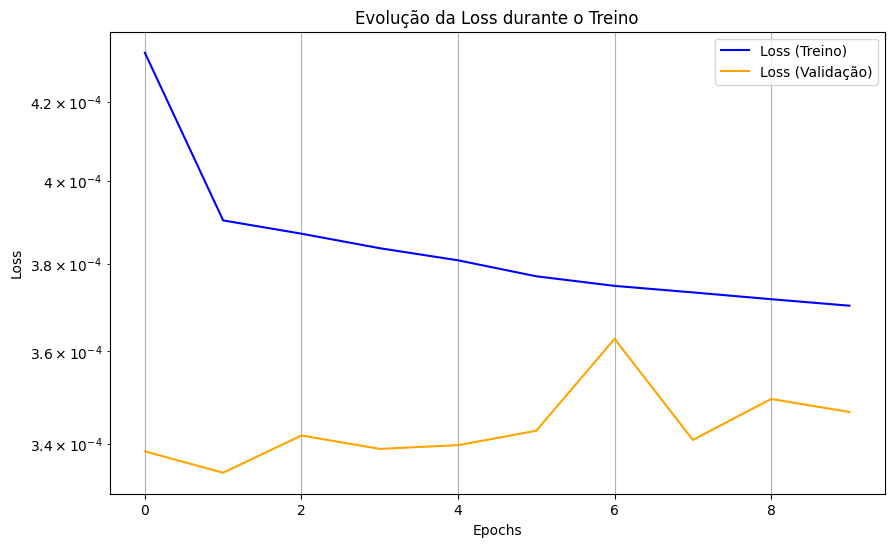

Loss no conjunto de teste: [0.00029001300572417676, 0.011582684703171253]


In [245]:
# Plot da evolução da loss (treinamento e validação)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Loss (Treino)', color='blue')
plt.plot(history.history['val_loss'], label='Loss (Validação)', color='orange')
plt.yscale('log')
plt.title('Evolução da Loss durante o Treino')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Avaliar a performance nos dados de teste
test_loss = lstm_model.evaluate(X_test_seq, y_test_seq, verbose=0)  
print(f"Loss no conjunto de teste: {test_loss}")

Decidimos guardar os valores reais e previstos num dataframe, designado "predicted_vs_real_25.csv".

In [246]:
#Guardar o csv com os valores reais e previstos
df_test.to_csv("predicted_vs_real_25.csv", index=True)
print("DataFrame guardado como 'predicted_vs_real_25.csv'.")

DataFrame guardado como 'predicted_vs_real_25.csv'.


# Valores Reais e Previsões

In [2]:
df_test=pd.read_csv("predicted_vs_real_25.csv")
df_test

Date  Real_Return  Predicted_Return  Ticker
0      2024-01-02 00:00:00+00:00    -0.035787          0.001644       0
1      2024-01-02 00:00:00+00:00    -0.007488         -0.002356       1
2      2024-01-02 00:00:00+00:00    -0.012700         -0.011210       2
3      2024-01-02 00:00:00+00:00    -0.004013         -0.004859       3
4      2024-01-02 00:00:00+00:00     0.024175         -0.008924       4
...                          ...          ...               ...     ...
10285  2024-01-31 00:00:00+00:00     0.008546         -0.002709     489
10286  2024-01-31 00:00:00+00:00     0.014047         -0.002147     490
10287  2024-01-31 00:00:00+00:00     0.010916          0.004975     491
10288  2024-01-31 00:00:00+00:00    -0.031129         -0.004055     492
10289  2024-01-31 00:00:00+00:00     0.022675         -0.004666     493

[10290 rows x 4 columns]

# **Monte Carlo**

O **Monte Carlo** foi desenvolvido com o objetivo de simular várias combinações de ações para encontrar a melhor estratégia de investimento, tendo por base o retono previsto e o retorno real.

Primeiro, implementámos a função *monte_carlo_selection* responsável por gerar combinações aleatórias de ações disponíveis em cada dia e por selecionar a melhor, ou seja, a que maximiza o retorno previsto.

Definimos também a função *optimize_portfolio*, que aplica a função anterior a vários dias consecutivos e organiza os resultados. 

In [3]:
def monte_carlo_selection(df_day, max_combinations=1000, explore_rate=0.1):
    tickers = df_day['Ticker'].unique()
    num_tickers = len(tickers)

    best_combination = None
    best_predicted_return = -np.inf
    best_real_return = -np.inf  # Inicializa o melhor retorno real

    for i in range(max_combinations):
        if random.random() < explore_rate and best_combination is not None:
            # Exploração: Modificar uma combinação já conhecida
            num_changes = random.randint(1, len(best_combination))
            random_combination = list(best_combination)
            for _ in range(num_changes):
                if random.random() < 0.5 and random_combination:
                    # Remove um ticker aleatório
                    random_combination.pop(random.randint(0, len(random_combination) - 1))
                else:
                    # Adiciona um novo ticker aleatório
                    available_tickers = list(set(tickers) - set(random_combination))
                    if available_tickers:  # Verificar se há tickers disponíveis
                        new_ticker = random.choice(available_tickers)
                        random_combination.append(new_ticker)
        else:
            # Exploração aleatória: Gerar uma nova combinação
            num_selected = random.randint(1, num_tickers)
            random_combination = random.sample(list(tickers), num_selected)

        # Filtrar o DataFrame para as ações na combinação
        df_comb = df_day[df_day['Ticker'].isin(random_combination)]
        
        # Calcular o retorno total previsto e real
        total_predicted_return = df_comb['Predicted_Return'].sum()
        total_real_return = df_comb['Real_Return'].sum()
        
        # Verificar se essa combinação é a melhor até agora
        if total_predicted_return > best_predicted_return and total_predicted_return > 0:
            best_combination = random_combination
            best_predicted_return = total_predicted_return
            best_real_return = total_real_return

    # Verificar se nenhuma combinação válida foi encontrada
    if best_combination is None:
        best_combination = []
        best_predicted_return = 0
        best_real_return = 0

    return {
        "best_combination": best_combination,
        "com_predicted_return": best_predicted_return,
        "com_real_return": best_real_return  
    }

# Aplicar a otimização por dia
def optimize_portfolio(df_test, max_combinations=1000):
    results = []
    for date, df_day in df_test.groupby('Date'):

        result = monte_carlo_selection(df_day, max_combinations=max_combinations)
        result['Date'] = date
        results.append(result)

    return pd.DataFrame(results)

In [249]:
results = optimize_portfolio(df_test)
results

best_combination  com_predicted_return  \
0   [331, 34, 66, 95, 438, 387, 465, 410, 274, 253...              0.413412   
1   [213, 485, 223, 1, 181, 170, 83, 377, 274, 29,...              0.067880   
2   [68, 98, 124, 168, 263, 451, 381, 63, 366, 101...              0.101477   
3   [116, 156, 428, 194, 128, 43, 65, 150, 399, 21...              0.089333   
4   [339, 233, 133, 398, 188, 294, 477, 175, 391, ...              0.077208   
5   [375, 296, 200, 152, 287, 141, 458, 483, 214, ...              0.247782   
6   [334, 315, 453, 258, 196, 144, 342, 285, 96, 4...              0.100473   
7   [476, 230, 141, 232, 378, 173, 260, 242, 486, ...              0.159413   
8   [316, 394, 232, 439, 93, 317, 368, 53, 153, 45...              0.108480   
9   [34, 286, 239, 99, 356, 32, 58, 209, 365, 118,...              0.194599   
10  [314, 239, 54, 456, 406, 482, 143, 84, 156, 30...              0.116618   
11  [393, 28, 321, 416, 168, 438, 19, 399, 244, 30...              0.156434   
12  [141, 291, 327, 245, 410, 25, 190, 129, 261, 9...              0.135290   
13  [183, 234, 395, 243, 386, 289, 175, 334, 189, ...              0.167770   
14  [213, 12, 79, 4, 216, 26, 156, 144, 15, 331, 1...              0.094535   
15  [134, 368, 196, 156, 457, 57, 378, 16, 135, 43...              0.127016   
16  [430, 186, 11, 396, 366, 461, 124, 138, 293, 3...              0.145964   
17  [204, 73, 246, 426, 286, 357, 359, 258, 37, 20...              0.159585   
18  [92, 389, 343, 227, 219, 174, 56, 449, 103, 28...              0.107521   
19  [29, 398, 402, 347, 470, 461, 381, 216, 146, 2...              0.224951   
20  [25, 390, 274, 80, 184, 131, 212, 259, 464, 37...              0.117533   

    com_real_return                       Date  
0          0.247469  2024-01-02 00:00:00+00:00  
1          0.091417  2024-01-03 00:00:00+00:00  
2         -0.174901  2024-01-04 00:00:00+00:00  
3          0.011741  2024-01-05 00:00:00+00:00  
4          0.018374  2024-01-08 00:00:00+00:00  
5          0.052537  2024-01-09 00:00:00+00:00  
6         -0.050285  2024-01-10 00:00:00+00:00  
7          0.280567  2024-01-11 00:00:00+00:00  
8          0.243053  2024-01-12 00:00:00+00:00  
9          0.252904  2024-01-16 00:00:00+00:00  
10         0.322355  2024-01-17 00:00:00+00:00  
11         0.148526  2024-01-18 00:00:00+00:00  
12         0.314725  2024-01-19 00:00:00+00:00  
13         0.121609  2024-01-22 00:00:00+00:00  
14        -0.067018  2024-01-23 00:00:00+00:00  
15        -0.037027  2024-01-24 00:00:00+00:00  
16         0.106887  2024-01-25 00:00:00+00:00  
17         0.280017  2024-01-26 00:00:00+00:00  
18         0.149977  2024-01-29 00:00:00+00:00  
19         0.273437  2024-01-30 00:00:00+00:00  
20        -0.093613  2024-01-31 00:00:00+00:00

# **Cálculo das Métricas**

- **Métricas financeiras**: Avaliam os retornos médios e acumulados, tanto previstos como reais, permitindo analisar o crescimento do portefólio ao longo do tempo.

- **Métricas de performance**: Medem a qualidade das previsões e a eficácia do portefólio para alcançar retornos positivos. Estas métricas envolvem a taxa de acerto, isto é, a proporção de dias com retornos reais positivos (*Hit Rate*), o erro absoluto médio (MAE) e o coeficiente de determinação (R²).

- **Métricas de risco**: Avaliam a relação entre o retorno e a volatilidade para determinar a eficiência do portefólio em gerar retornos ajustados ao risco (*Sharpe Ratio* real e previsto).

- **Métricas diárias**: Estas métricas, retorno médio diário, volatilidade diária e *Sharpe Ration*, avaliam a performance do modelo diariamente.

In [251]:
def evaluate_model_performance(results_df):
    # Filtrar apenas dias com combinações selecionadas
    selected_days = results_df[results_df['best_combination'].apply(len) > 0].copy()  # Adicionar .copy() aqui
    
    # Retornos previstos e reais
    predicted_returns = selected_days['com_predicted_return']
    real_returns = selected_days['com_real_return']
    
    # Cálculo de métricas principais
    metrics = {}
    metrics['Average_Predicted_Return'] = predicted_returns.mean()
    metrics['Average_Real_Return'] = real_returns.mean()
    metrics['Hit_Rate'] = (real_returns > 0).mean()
    metrics['MAE'] = np.mean(np.abs(predicted_returns - real_returns))
    metrics['R2'] = r2(real_returns, predicted_returns) if len(real_returns) > 1 else np.nan
    metrics['Sharpe_Ratio_Real'] = (
        real_returns.mean() / real_returns.std() if real_returns.std() > 0 else np.nan
    )
    metrics['Sharpe_Ratio_Predicted'] = (
        predicted_returns.mean() / predicted_returns.std() if predicted_returns.std() > 0 else np.nan
    )
    
    # Cálculo de retornos acumulados
    selected_days.loc[:, 'Cumulative_Real_Return'] = (1 + real_returns).cumprod()
    selected_days.loc[:, 'Cumulative_Predicted_Return'] = (1 + predicted_returns).cumprod()
    
    metrics['Cumulative_Real_Return_Final'] = selected_days['Cumulative_Real_Return'].iloc[-1]
    metrics['Cumulative_Predicted_Return_Final'] = selected_days['Cumulative_Predicted_Return'].iloc[-1]
    
    # Cálculo de retornos diários com base nos acumulados
    selected_days.loc[:, 'daily_real_return'] = selected_days['Cumulative_Real_Return'].pct_change()
    selected_days.loc[:, 'daily_predicted_return'] = selected_days['Cumulative_Predicted_Return'].pct_change()
    
    metrics['Daily_Mean_Real_Return'] = selected_days['daily_real_return'].mean()
    metrics['Daily_Mean_Predicted_Return'] = selected_days['daily_predicted_return'].mean()
    metrics['Daily_Std_Real_Return'] = selected_days['daily_real_return'].std()
    metrics['Daily_Std_Predicted_Return'] = selected_days['daily_predicted_return'].std()
    
    # Sharpe Ratios diários
    metrics['Sharpe_Ratio_Daily_Real'] = (
        metrics['Daily_Mean_Real_Return'] / metrics['Daily_Std_Real_Return']
        if metrics['Daily_Std_Real_Return'] > 0 else np.nan
    )
    metrics['Sharpe_Ratio_Daily_Predicted'] = (
        metrics['Daily_Mean_Predicted_Return'] / metrics['Daily_Std_Predicted_Return']
        if metrics['Daily_Std_Predicted_Return'] > 0 else np.nan
    )
    
    # Formatar resultados para apresentação
    formatted_results = f"""
    ### Resumo de Desempenho do Modelo Preditivo ###
    
    **Métricas de Retorno:**
    - Retorno Médio Previsto: {metrics['Average_Predicted_Return']:.4f}
    - Retorno Médio Real: {metrics['Average_Real_Return']:.4f}
    - Retorno Acumulado Final (Real): {metrics['Cumulative_Real_Return_Final']:.4f}
    - Retorno Acumulado Final (Previsto): {metrics['Cumulative_Predicted_Return_Final']:.4f}
    
    **Métricas de Performance:**
    - Taxa de Acerto (Hit Rate): {metrics['Hit_Rate']:.2%}
    - Erro Absoluto Médio (MAE): {metrics['MAE']:.4f}
    - Coeficiente de Determinação (R²): {metrics['R2']:.4f}
    
    **Métricas de Risco:**
    - Sharpe Ratio (Real): {metrics['Sharpe_Ratio_Real']:.4f}
    - Sharpe Ratio (Previsto): {metrics['Sharpe_Ratio_Predicted']:.4f}
    
    **Métricas Diárias:**
    - Retorno Médio Diário (Real): {metrics['Daily_Mean_Real_Return']:.4f}
    - Retorno Médio Diário (Previsto): {metrics['Daily_Mean_Predicted_Return']:.4f}
    - Volatilidade Diária (Real): {metrics['Daily_Std_Real_Return']:.4f}
    - Volatilidade Diária (Previsto): {metrics['Daily_Std_Predicted_Return']:.4f}
    - Sharpe Ratio Diário (Real): {metrics['Sharpe_Ratio_Daily_Real']:.4f}
    - Sharpe Ratio Diário (Previsto): {metrics['Sharpe_Ratio_Daily_Predicted']:.4f}
    """
    
    print(formatted_results)

# **Desempenho do LSTM**

In [252]:
evaluate_model_performance(results)


    ### Resumo de Desempenho do Modelo Preditivo ###
    
    **Métricas de Retorno:**
    - Retorno Médio Previsto: 0.1483
    - Retorno Médio Real: 0.1187
    - Retorno Acumulado Final (Real): 8.7316
    - Retorno Acumulado Final (Previsto): 17.4979
    
    **Métricas de Performance:**
    - Taxa de Acerto (Hit Rate): 76.19%
    - Erro Absoluto Médio (MAE): 0.1185
    - Coeficiente de Determinação (R²): 0.1582
    
    **Métricas de Risco:**
    - Sharpe Ratio (Real): 0.7884
    - Sharpe Ratio (Previsto): 1.9375
    
    **Métricas Diárias:**
    - Retorno Médio Diário (Real): 0.1123
    - Retorno Médio Diário (Previsto): 0.1350
    - Volatilidade Diária (Real): 0.1515
    - Volatilidade Diária (Previsto): 0.0477
    - Sharpe Ratio Diário (Real): 0.7412
    - Sharpe Ratio Diário (Previsto): 2.8289
    


Tendo por base as métricas anteriores, podemos dizer que a LSTM apresentou, de modo geral, um bom desempenho geral. No entanto, consideramos que para além dos diversos pontos fortes, apresenta alguns pontos fracos. 
\
Por uma lado, a Taxa de Acerto (Hit Rate) de 76.19% é notavelmente positiva, o que sugere que o modelo é capaz de capturar direções de mercado de forma confiável. Simultaneamente, o Erro Absoluto Médio (MAE) de 0.1185 é bastante reduzido, o que indica uma boa precisão em valores absolutos.
\
Por outro lado, o baixo valor de R² reflete uma capacidade limitada de explicar a variabilidade dos retornos reais. Existe um padrão de otimismo nas previsões, com retornos previstos consistentemente superiores aos reais e subestimação da volatilidade.

# **Conclusões**

Após realizarmos uma análise das métricas de desempenho dos quatro modelos implementados, podemos concluir que o **AdaBoost** apresenta o melhor desempenho geral pelos seguintes motivos:

- Capacidade de Explicação (R²): O AdaBoost possui o maior valor de R² (0.9856), o que indica uma excelente capacidade de explicar a variabilidade dos retornos, superando os outros modelos.

- Taxa de Acerto (Hit Rate): A taxa de acerto de 73.33% é sólida, especialmente quando comparada aos outros modelos, e demonstra a boa capacidade do modelo em capturar direções de mercado.

- Gestão de Risco (Sharpe Ratio): O Sharpe Ratio previsto de 1.2402 reflete uma boa consistência ajustada ao risco, superando os outros modelos, apesar do Sharpe Ratio real ser inferior.

- Retornos e Volatilidade: Embora o modelo subestime os retornos reais, os retornos acumulados previstos estão próximos dos reais, e a volatilidade prevista é controlada, indicando uma boa gestão de risco.

Em suma, o AdaBoost combina alta explicabilidade, boa taxa de acerto, consistência ajustada ao risco e estabilidade nas previsões, tornando-o a melhor escolha